# 02: Geoprocessing


## imports


In [1]:
import pyogrio as ogr
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import geopandas as gpd
from lonboard import Map, PolygonLayer
from lonboard.colormap import apply_categorical_cmap

# done
# spatial join
# buildings to tax lots
# buildings in 3d with lonboard
# dissolve tax lot by lu or by owner

# not done
# union tax lots and sidewalk to get blocks in total
# intersect to show non-building area
# calculate soft site potential based on FAR, lot size, building class

In [2]:
cb_307 = ogr.read_dataframe(
    "../Data/nyc_mappluto_24v1_1_shp/mappluto_ogr.fgb", where="CD = 307"
)

<Axes: >

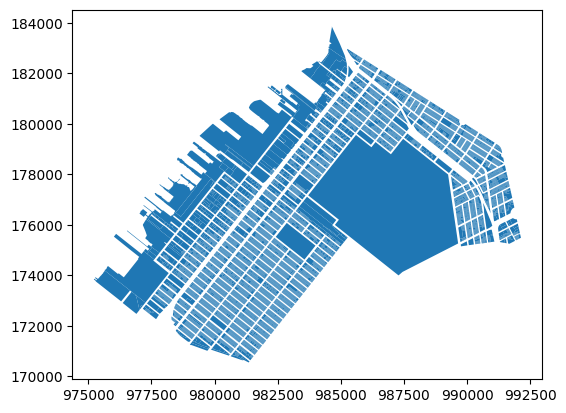

In [3]:
cb_307.plot()

In [4]:
# get maximum bounding geometry for all tax lots
bounds = cb_307.total_bounds

In [5]:
bounds_poly = gpd.GeoSeries(
    Polygon(
        [
            [bounds[0], bounds[1]],
            [bounds[0], bounds[3]],
            [bounds[2], bounds[3]],
            [bounds[2], bounds[1]],
            [bounds[0], bounds[1]],
        ]
    )
)

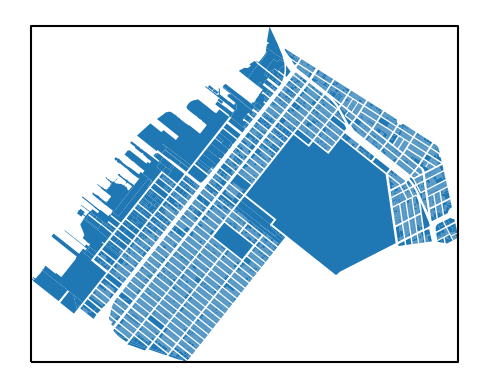

In [6]:
ax = cb_307.plot()
bounds_poly.boundary.plot(ax=ax, color="black").set_axis_off()

In [7]:
bounds_poly

0    POLYGON ((975222.902 170552.422, 975222.902 18...
dtype: geometry

In [8]:
bounds_poly.crs = cb_307.crs

In [9]:
bounds_poly.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## reproject


In [10]:
bounds_poly_wgs84 = bounds_poly.to_crs("EPSG:4326")

In [11]:
cb_307_bldgs = ogr.read_dataframe(
    "../Data/bldg_footprints/Building Footprints.geojson",
    mask=bounds_poly_wgs84[0],
)

<Axes: >

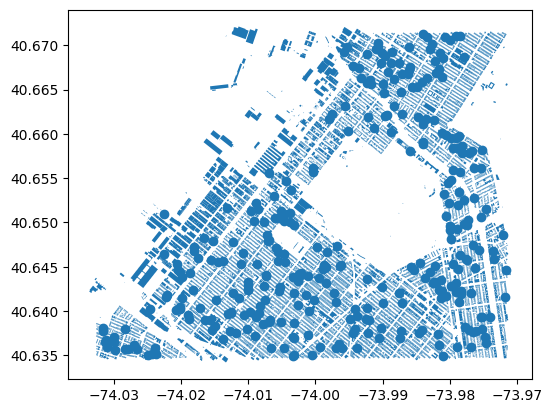

In [12]:
cb_307_bldgs.plot()

In [13]:
cb_307_bldgs = cb_307_bldgs[cb_307_bldgs.geometry.type != "Point"]

<Axes: >

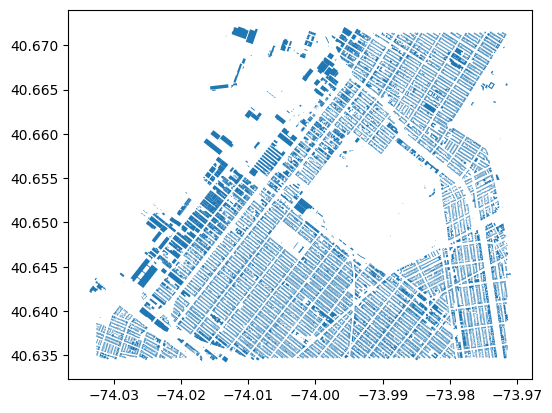

In [14]:
cb_307_bldgs.plot()

In [15]:
cb_307_bldgs = cb_307_bldgs.to_crs(cb_307.crs)

In [16]:
cb_307.BoroCode

0        3
1        3
2        3
3        3
4        3
        ..
13279    3
13280    3
13281    3
13282    3
13283    3
Name: BoroCode, Length: 13284, dtype: int64

## spatial join


In [17]:
cb_307_bldgs["rep_pt"] = cb_307_bldgs.representative_point()
cb_307_bldgs.set_geometry("rep_pt", inplace=True)

In [18]:
cb_307_bldgs.base_bbl.nunique(), cb_307_bldgs.shape[0], cb_307_bldgs.globalid.nunique()

(26358, 30110, 30110)

In [19]:
cb_307_bldgs

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,globalid,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,geometry,rep_pt
0,None,3008130054,0.0,31.05,3008130054,1901,{C2B6150A-AA05-4865-B836-9DFA5C153E9C},Constructed,2100,48,Photogramm,3014166,2017-08-22,392052,0.0,"MULTIPOLYGON (((979424.884 174653.762, 979393....",POINT (979402.531 174638.900)
1,None,3010120038,0.0,42.44,3010120038,1921,{65E24ABD-485B-4B01-B70E-5ACA0E221B53},Constructed,2100,115,Photogramm,3022371,2017-08-22,743038,0.0,"MULTIPOLYGON (((989250.122 182249.393, 989226....",POINT (989230.470 182235.219)
2,None,3053130127,0.0,26.38239517,3053130127,1940,{454D03AE-5F41-4886-A5C5-74DD122005EF},Constructed,2100,57,Photogramm,3123939,2017-08-22,785686,0.0,"MULTIPOLYGON (((989342.250 173309.206, 989328....",POINT (989345.270 173325.920)
3,None,3058710090,0.0,24.71,3058710090,1920,{F02017F9-C56E-4793-96D1-03741F2569AC},Constructed,2100,73,Photogramm,3145644,2017-08-22,560761,0.0,"MULTIPOLYGON (((976372.261 170905.430, 976404....",POINT (976382.124 170892.831)
4,None,3058850095,0.0,26.79,3058850095,1925,{D97E7A81-466F-47F7-9159-D52052EC7129},Constructed,2100,68,Photogramm,3146300,2017-08-22,541427,0.0,"MULTIPOLYGON (((975991.817 170852.230, 975985....",POINT (975969.477 170848.875)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30105,None,3055910017,0.0,60.0,3055917508,2008,{F565CBEB-73A0-4C8B-8ACF-D7E26DEDFB03},Constructed,2100,74,Other (Man,3394074,2024-05-29,1100472,0.0,"MULTIPOLYGON (((986063.897 173535.911, 986025....",POINT (986034.911 173520.284)
30106,None,3006390016,0.0,None,3006390016,2021,{019343C0-3AC3-47DE-9C68-0011F8B5B7AD},Constructed,2100,18,Other (Man,3009227,2024-05-03,1294399,0.0,"MULTIPOLYGON (((985148.458 181241.335, 985161....",POINT (985116.244 181187.492)
30107,None,3007280036,0.0,60.0,3007280036,2024,{041C01B4-5A94-46C4-A3BB-0457C706C8BC},Constructed,2100,63,Other (Man,3426350,2024-06-20,1302168,0.0,"MULTIPOLYGON (((981766.623 176163.648, 981761....",POINT (981725.644 176235.773)
30108,None,3010510039,0.0,120.0,3010510039,2023,{0007187C-0E44-4204-AFE4-F9C3FC0C1DA8},Constructed,2100,46,Other (Man,3024085,2024-06-18,1302163,0.0,"MULTIPOLYGON (((986145.791 181865.976, 986188....",POINT (986220.175 181831.511)


In [20]:
## spatial join buildings to tax lots based on building representative point
bldgs_w_lot = cb_307_bldgs[["globalid", "mpluto_bbl", "rep_pt"]].sjoin(
    cb_307, how="inner", op="within"
)

c:\Users\user\anaconda3\envs\CDP\Lib\site-packages\IPython\core\interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
bldgs_w_lot_nearest = cb_307_bldgs[["globalid", "mpluto_bbl", "rep_pt"]].sjoin_nearest(
    cb_307, how="left", distance_col="distance"
)

<Axes: >

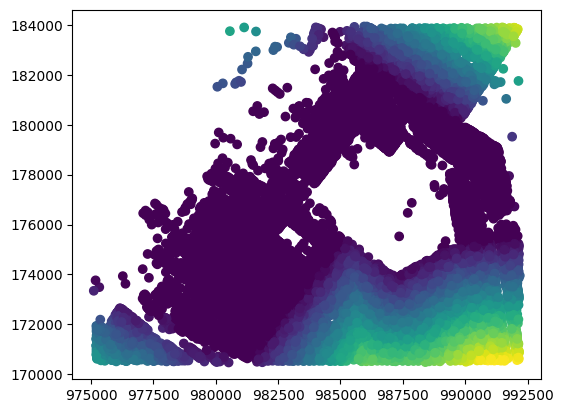

In [22]:
bldgs_w_lot_nearest.plot("distance")

<Axes: >

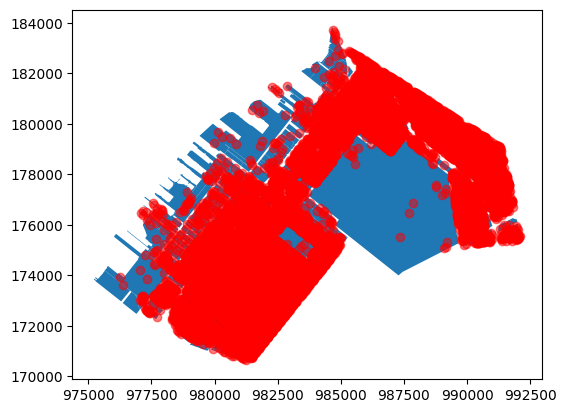

In [23]:
ax = cb_307.plot()
bldgs_w_lot.plot(ax=ax, color="red", alpha=0.5)

In [24]:
## drop cases where there is no match (i.e. no tax lot for buildings)

In [25]:
# now, join back to original building footprints
bldgs_w_lot = bldgs_w_lot.drop(columns=["rep_pt"]).merge(
    cb_307_bldgs, on="globalid", how="left"
)

In [26]:
bldgs_w_lot_gdf = gpd.GeoDataFrame(bldgs_w_lot, geometry="geometry")

In [27]:
bldgs_w_lot_gdf.LandUse.head()

0    01
1    08
2    06
3    04
4    01
Name: LandUse, dtype: object

In [59]:
# now we can remap the numbers into something more meaningful

land_use_codes = {
    "01": "One & Two Family Buildings",
    "02": "Multi-Family Walk-Up Buildings",
    "03": "Multi-Family Elevator Buildings",
    "04": "Mixed Residential & Commercial Buildings",
    "05": "Commercial & Office Buildings",
    "06": "Industrial & Manufacturing",
    "07": "Transportation & Utility",
    "08": "Public Facilities & Institutions",
    "09": "Open Space & Outdoor Recreation",
    "10": "Parking Facilities",
    "11": "Vacant Land"
}

In [29]:
bldgs_w_lot_gdf['LandUse']

0        01
1        08
2        06
3        04
4        01
         ..
14310    03
14311    05
14312    08
14313    04
14314    11
Name: LandUse, Length: 14315, dtype: object

In [30]:
bldgs_w_lot_gdf['LandUse'] = bldgs_w_lot_gdf['LandUse'].map(land_use_codes)

In [31]:
bldgs_w_lot_gdf["LandUse"]

0                      One & Two Family Buildings
1                Public Facilities & Institutions
2                      Industrial & Manufacturing
3        Mixed Residential & Commercial Buildings
4                      One & Two Family Buildings
                           ...                   
14310             Multi-Family Elevator Buildings
14311               Commercial & Office Buildings
14312            Public Facilities & Institutions
14313    Mixed Residential & Commercial Buildings
14314                                 Vacant Land
Name: LandUse, Length: 14315, dtype: object

In [60]:
cmap = {
    "One & Two Family Buildings": "#ff0000",
    "Multi-Family Walk-Up Buildings": "#00ff00",
    "Multi-Family Elevator Buildings": "#0000ff",
    "Mixed Residential & Commercial Buildings": "#ff00ff",
    "Commercial & Office Buildings": "#00ffff",
    "Industrial & Manufacturing": "#ffff00",
    "Transportation & Utility": "#808080",
    "Public Facilities & Institutions": "#800000",
    "Open Space & Outdoor Recreation": "#008000",
    "Parking Facilities": "#000080",
    "Vacant Land": "#800080",
    "Unknown": "#000000",
}

In [33]:
bldgs_w_lot_gdf['color'] = bldgs_w_lot_gdf['LandUse'].map(cmap)

In [34]:
bldgs_w_lot_gdf['LandUse']

0                      One & Two Family Buildings
1                Public Facilities & Institutions
2                      Industrial & Manufacturing
3        Mixed Residential & Commercial Buildings
4                      One & Two Family Buildings
                           ...                   
14310             Multi-Family Elevator Buildings
14311               Commercial & Office Buildings
14312            Public Facilities & Institutions
14313    Mixed Residential & Commercial Buildings
14314                                 Vacant Land
Name: LandUse, Length: 14315, dtype: object

In [61]:
cmap_rgb = {k: list(int(v[i : i + 2], 16) for i in (1, 3, 5)) for k, v in cmap.items()}

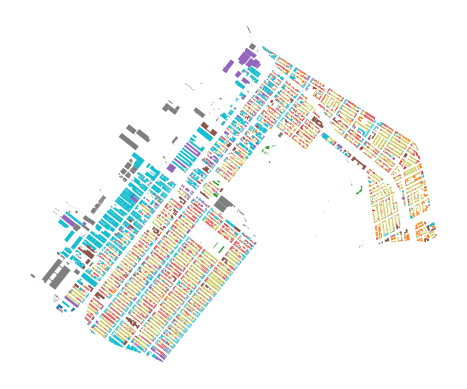

In [36]:
bldgs_w_lot_gdf.plot(column='color').set_axis_off()

In [37]:
bldgs_w_lot_gdf.fillna({"LandUse": "Unknown"}, inplace=True)

In [38]:
cmap_rgb

{'One & Two Family Buildings': [255, 0, 0],
 'Multi-Family Walk-Up Buildings': [0, 255, 0],
 'Multi-Family Elevator Buildings': [0, 0, 255],
 'Mixed Residential & Commercial Buildings': [255, 0, 255],
 'Commercial & Office Buildings': [0, 255, 255],
 'Industrial & Manufacturing': [255, 255, 0],
 'Transportation & Utility': [128, 128, 128],
 'Public Facilities & Institutions': [128, 0, 0],
 'Open Space & Outdoor Recreation': [0, 128, 0],
 'Parking Facilities': [0, 0, 128],
 'Vacant Land': [128, 0, 128],
 'Unknown': [0, 0, 0]}

In [39]:
# make a lonboard plot with color based on land use and height based on number of floors
heights = bldgs_w_lot_gdf["heightroof"].astype(float).to_numpy()
bldgs_layer = PolygonLayer.from_geopandas(
    bldgs_w_lot_gdf[["geometry", "LandUse"]],
    get_fill_color=apply_categorical_cmap(bldgs_w_lot_gdf["LandUse"], cmap=cmap_rgb),
    extruded=True,
    get_elevation=heights,
)

m = Map(
    [bldgs_layer],
    view_state={
        "pitch": 45,
        "zoom": 14,
        "latitude": 40.6459406,
        "longitude": -74.0151512,
    },
)
m

c:\Users\user\anaconda3\envs\CDP\Lib\site-packages\lonboard\_geoarrow\ops\reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


Map(layers=[PolygonLayer(extruded=True, get_elevation=<pyarrow.lib.FloatArray object at 0x0000029D988E57E0>
[
…

## attribute join


... sometimes it makes more sense to join based on attributes rather than spatial relationships. This is one of those cases.


In [40]:
cb_307_bldgs.mpluto_bbl.nunique(), cb_307.shape

(26321, (13284, 95))

In [41]:
cb_307.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

In [42]:
cb_307_bldgs.mpluto_bbl.dtype, cb_307.BBL.dtype

(dtype('O'), dtype('float64'))

In [43]:
cb_307_bldgs["mpluto_bbl"] = cb_307_bldgs["mpluto_bbl"].astype(float)

In [47]:
cb_307_bldgs.mpluto_bbl

0        3.008130e+09
1        3.010120e+09
2        3.053130e+09
3        3.058710e+09
4        3.058850e+09
             ...     
30105    3.055918e+09
30106    3.006390e+09
30107    3.007280e+09
30108    3.010510e+09
30109    3.008500e+09
Name: mpluto_bbl, Length: 30110, dtype: float64

In [44]:
bldgs_w_lot_attrib = cb_307_bldgs.merge(
    cb_307, left_on="mpluto_bbl", right_on="BBL", how="inner"
)

In [49]:
print(bldgs_w_lot_attrib)

       name    base_bbl shape_area heightroof    mpluto_bbl cnstrct_yr  \
0      None  3008130054        0.0      31.05  3.008130e+09       1901   
1      None  3008370001        0.0      64.47  3.008370e+09       1994   
2      None  3007890064        0.0      25.85  3.007890e+09       1931   
3      None  3052800064        0.0      23.66  3.052800e+09       1931   
4      None  3011150070        0.0      30.11  3.011150e+09       1901   
...     ...         ...        ...        ...           ...        ...   
14311  None  3009000063        0.0       50.0  3.009008e+09       2019   
14312  None  3006390016        0.0       None  3.006390e+09       2021   
14313  None  3007280036        0.0       60.0  3.007280e+09       2024   
14314  None  3010510039        0.0      120.0  3.010510e+09       2023   
14315  None  3008500069        0.0       36.0  3.008500e+09       2024   

                                     globalid   lststatype feat_code  \
0      {C2B6150A-AA05-4865-B836-9DFA5C1

In [45]:
# assert bldgs_w_lot_attrib.shape == bldgs_w_lot_gdf.shape
bldgs_w_lot_attrib.shape == bldgs_w_lot_gdf.shape

False

<Axes: >

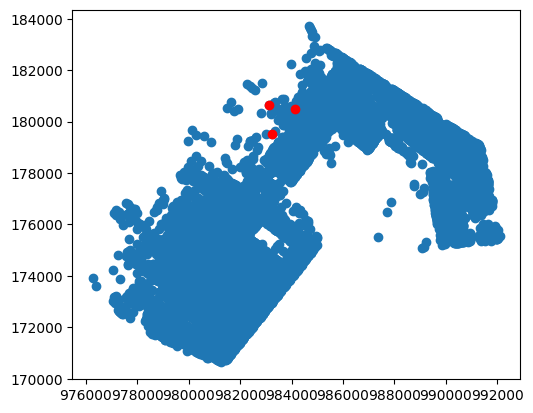

In [46]:
# find the globalid of the buildings in bldgs_w_lot_attrib that are not in bldgs_w_lot_gdf
ax = bldgs_w_lot_attrib.plot()
bldgs_w_lot_attrib[~bldgs_w_lot_attrib.globalid.isin(bldgs_w_lot_gdf.globalid)].plot(
    ax=ax, color="red"
)

In [50]:
missing_buildings = bldgs_w_lot_attrib[
    ~bldgs_w_lot_attrib.globalid.isin(bldgs_w_lot_gdf.globalid)
].globalid.unique()

In [51]:
missing_buildings

array(['{5BA6B597-2763-493D-878C-A310997C62D1}',
       '{4661736C-007A-49C3-9E92-7E39576F9255}',
       '{F856BB3E-ED5E-4966-B2D2-C2520BB0F7AB}'], dtype=object)

In [52]:
bldgs_w_lot_attrib["geometry"] = bldgs_w_lot_attrib["geometry_x"]

In [53]:
bldgs_w_lot_attrib.set_geometry("geometry", inplace=True)

In [55]:
bldgs_w_lot_attrib

,name,base_bbl,shape_area,heightroof,mpluto_bbl,cnstrct_yr,globalid,lststatype,feat_code,groundelev,...,PFIRM15_FL,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry_y,geometry
0,None,3008130054,0.0,31.05,3.008130e+09,1901,{C2B6150A-AA05-4865-B836-9DFA5C153E9C},Constructed,2100,48,...,None,24v1.1,None,40.646041,-74.017448,None,0.0,1756.742220,"MULTIPOLYGON (((979369.047 174612.710, 979433....","MULTIPOLYGON (((979424.884 174653.762, 979393...."
1,None,3008370001,0.0,64.47,3.008370e+09,1994,{6290F624-6A8D-482F-8BD9-57C27337D89F},Constructed,2100,36,...,None,24v1.1,None,40.645239,-74.020500,None,0.0,19141.495406,"MULTIPOLYGON (((978622.171 174415.821, 978651....","MULTIPOLYGON (((978615.393 174418.816, 978592...."
2,None,3007890064,0.0,25.85,3.007890e+09,1931,{F68D5818-C246-4828-A454-10D28962217D},Constructed,2100,32,...,None,24v1.1,None,40.648210,-74.016515,None,0.0,6152.697688,"MULTIPOLYGON (((979658.965 175378.734, 979612....","MULTIPOLYGON (((979722.511 175458.427, 979700...."
3,None,3052800064,0.0,23.66,3.052800e+09,1931,{441DAB8C-3423-4722-ABDE-4BFE5A472C2B},Constructed,2100,62,...,None,24v1.1,None,40.648203,-73.979830,None,0.0,2138.490866,"MULTIPOLYGON (((989842.608 175466.797, 989842....","MULTIPOLYGON (((989834.116 175442.434, 989851...."
4,None,3011150070,0.0,30.11,3.011150e+09,1901,{B8BC6B19-B2E4-4842-8B03-5C28CC13A572},Constructed,2100,147,...,None,24v1.1,None,40.657928,-73.978234,None,0.0,2055.187662,"MULTIPOLYGON (((990254.404 178941.971, 990307....","MULTIPOLYGON (((990301.650 178978.578, 990273...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14311,None,3009000063,0.0,50.0,3.009008e+09,2019,{EC248E59-BB81-4165-A0CF-C0CDB0689BDA},Constructed,2100,125,...,None,24v1.1,None,40.658726,-73.991638,None,0.0,7977.884302,"MULTIPOLYGON (((986632.532 179283.155, 986569....","MULTIPOLYGON (((986516.044 179263.976, 986551...."
14312,None,3006390016,0.0,None,3.006390e+09,2021,{019343C0-3AC3-47DE-9C68-0011F8B5B7AD},Constructed,2100,18,...,None,24v1.1,None,40.664040,-73.996832,None,0.0,1636.504799,"MULTIPOLYGON (((985166.923 181238.777, 985104....","MULTIPOLYGON (((985148.458 181241.335, 985161...."
14313,None,3007280036,0.0,60.0,3.007280e+09,2024,{041C01B4-5A94-46C4-A3BB-0457C706C8BC},Constructed,2100,63,...,None,24v1.1,t,40.650423,-74.009020,None,0.0,13248.661347,"MULTIPOLYGON (((981829.907 176243.752, 981766....","MULTIPOLYGON (((981766.623 176163.648, 981761...."
14314,None,3010510039,0.0,120.0,3.010510e+09,2023,{0007187C-0E44-4204-AFE4-F9C3FC0C1DA8},Constructed,2100,46,...,None,24v1.1,None,40.665840,-73.992939,None,0.0,7351.776115,"MULTIPOLYGON (((986198.018 181910.649, 986213....","MULTIPOLYGON (((986145.791 181865.976, 986188...."


### investigate- what's going on??


In [62]:
# make a lonboard plot with color based on land use and height based on number of floors

missing_bldgs = bldgs_w_lot_attrib[bldgs_w_lot_attrib.globalid.isin(missing_buildings)]

heights_missing = missing_bldgs["heightroof"].astype(float).to_numpy()

lots_layer = PolygonLayer.from_geopandas(
    cb_307[["geometry", "LandUse"]],
    get_fill_color=apply_categorical_cmap(cb_307["LandUse"], cmap=cmap_rgb),
)

missing_bldgs_layer = PolygonLayer.from_geopandas(
    missing_bldgs[["geometry", "LandUse"]],
    get_fill_color=[255, 0, 0, 155],
    extruded=True,
    get_elevation=heights_missing,
)

m = Map(
    [missing_bldgs_layer, lots_layer],
    view_state={
        "pitch": 45,
        "zoom": 14,
        "latitude": 40.6459406,
        "longitude": -74.0151512,
    },
)


KeyError: '07'

So we can see that there are three cases where buildings are associated with lots, even if their representative point (or entire geometry) fall outside of the actual polygon.


## dissolve


Learn more about dissolve here: https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html


In [63]:
cb_307_by_owner = cb_307.dissolve(
    by="OwnerName",
    aggfunc={
        "LandUse": list,
        "LotArea": "sum",
    },
).reset_index()

In [68]:
cb_307_by_owner

,OwnerName,geometry,LandUse,LotArea
0,*** NO OWNER FOUND ***,"POLYGON ((980590.724 174235.587, 980527.813 17...",[01],2003
1,1-10 BUSH TERMINAL OWNER LP,"POLYGON ((982202.987 178074.791, 982200.638 17...","[05, 06, 06, 05, 06, 10, 06, 05]",722097
2,10 E 4TH STREET LLC,"POLYGON ((990181.201 176930.755, 990282.152 17...",[02],2050
3,10-16 OCEAN REALTIES,"POLYGON ((991792.749 176633.932, 991787.150 17...",[03],42968
4,100 19TH STREET,"POLYGON ((989711.736 177970.244, 989649.158 17...",[02],6010
...,...,...,...,...
12136,"ZWERLING, CARA","POLYGON ((990576.588 178737.293, 990630.331 17...",[01],2000
12137,"ZWICK, ELAINE R","POLYGON ((990085.407 178976.260, 990103.152 17...",[02],2000
12138,ZWL REALTY LLC,"POLYGON ((983015.618 174308.387, 982951.592 17...",[02],2003
12139,ZY MANAGEMENT LLC,"POLYGON ((981487.360 171696.522, 981474.555 17...",[04],2017


Text(0.5, 1.0, 'Top 10 Owners by Lot Area')

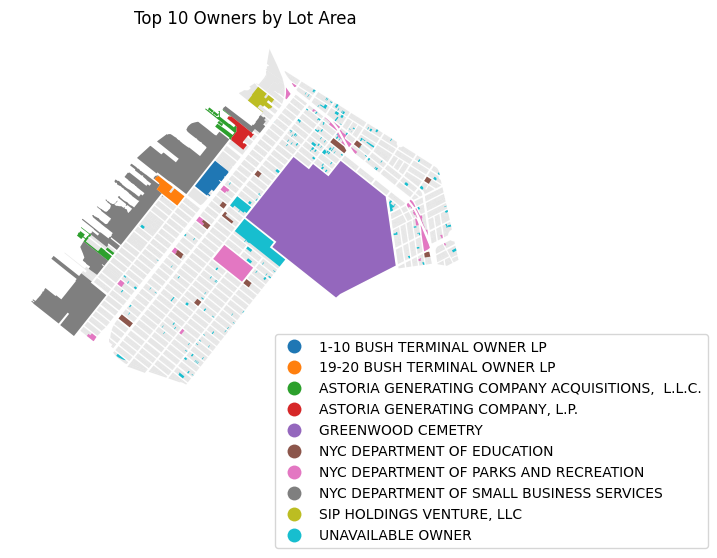

In [64]:
fig, ax = plt.subplots()
cb_307.plot(color="#cecece", ax=ax, alpha=0.5)

cb_307_by_owner.sort_values("LotArea", ascending=False).head(10).plot(
    column="OwnerName", legend=True, ax=ax
).set_axis_off()


# get legend item
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.0, 0.0, 0.5, 0.2))
ax.set_title("Top 10 Owners by Lot Area")
# put legend off the plot
# cb_307_by_owner.plot(column="OwnerName", legend=False)

In [65]:
cb_307_by_owner

,OwnerName,geometry,LandUse,LotArea
0,*** NO OWNER FOUND ***,"POLYGON ((980590.724 174235.587, 980527.813 17...",[01],2003
1,1-10 BUSH TERMINAL OWNER LP,"POLYGON ((982202.987 178074.791, 982200.638 17...","[05, 06, 06, 05, 06, 10, 06, 05]",722097
2,10 E 4TH STREET LLC,"POLYGON ((990181.201 176930.755, 990282.152 17...",[02],2050
3,10-16 OCEAN REALTIES,"POLYGON ((991792.749 176633.932, 991787.150 17...",[03],42968
4,100 19TH STREET,"POLYGON ((989711.736 177970.244, 989649.158 17...",[02],6010
...,...,...,...,...
12136,"ZWERLING, CARA","POLYGON ((990576.588 178737.293, 990630.331 17...",[01],2000
12137,"ZWICK, ELAINE R","POLYGON ((990085.407 178976.260, 990103.152 17...",[02],2000
12138,ZWL REALTY LLC,"POLYGON ((983015.618 174308.387, 982951.592 17...",[02],2003
12139,ZY MANAGEMENT LLC,"POLYGON ((981487.360 171696.522, 981474.555 17...",[04],2017


## Intersect / Difference


In [66]:
sample_block = cb_307.Block.sample(1).values[0]

In [67]:
sample_block

5273

In [69]:
cb_307_bldgs.columns

Index(['name', 'base_bbl', 'shape_area', 'heightroof', 'mpluto_bbl',
       'cnstrct_yr', 'globalid', 'lststatype', 'feat_code', 'groundelev',
       'geomsource', 'bin', 'lstmoddate', 'doitt_id', 'shape_len', 'geometry',
       'rep_pt'],
      dtype='object')

In [70]:
sample_block_lots = cb_307[cb_307.Block.eq(sample_block)].copy()
sample_block_bldgs = cb_307_bldgs[
    cb_307_bldgs.mpluto_bbl.isin(sample_block_lots.BBL.unique())
].copy()

In [71]:
sample_block_bldgs.set_geometry("geometry", inplace=True)

Text(0.5, 1.0, 'Block 5273')

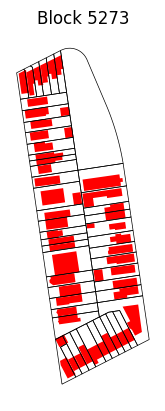

In [72]:
ax = sample_block_lots.boundary.plot(color="black", linewidth=0.5)
sample_block_bldgs.plot(ax=ax, color="red").set_axis_off()

ax.set_title(f"Block {sample_block}")

In [73]:
sample_block_non_bldg = sample_block_lots.difference(sample_block_bldgs.unary_union)

In [74]:
sample_block_non_bldg.shape

(50,)

<Axes: >

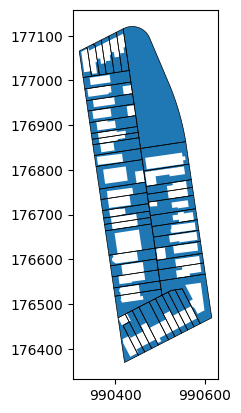

In [76]:
ax = sample_block_lots.boundary.plot(color="black", linewidth=0.5)
sample_block_non_bldg.plot(ax=ax)
#sample_block_bldgs.plot(ax=ax, color="orange").set_axis_off()

In [77]:
sample_block_non_bldg_intersect = sample_block_lots.intersection(
    sample_block_bldgs.unary_union
)

In [78]:
sample_block_non_bldg_intersect.shape

(50,)

<Axes: >

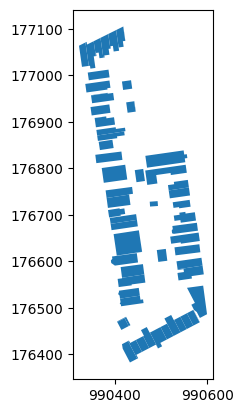

In [79]:
sample_block_non_bldg_intersect.plot()

## Union


In [80]:
sample_block_lots["lot_area"] = sample_block_lots.area

In [81]:
lots_bldgs_union = gpd.overlay(sample_block_lots, sample_block_bldgs, how="union")

In [82]:
lots_bldgs_union.shape

(144, 112)

In [83]:
import pandas as pd

In [84]:
lots_bldgs_union

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,lststatype,feat_code,groundelev,geomsource,bin,lstmoddate,doitt_id,shape_len,rep_pt,geometry
0,BK,5273.0,47.0,307.0,3150200,31502001001,1502,1001,15,39.0,...,Constructed,5110,64,Photogramm,3382214,2017-08-17,974741,0.0,POINT (990419.825 176466.390),"POLYGON ((990405.870 176469.426, 990421.808 17..."
1,BK,5273.0,47.0,307.0,3150200,31502001001,1502,1001,15,39.0,...,Constructed,2100,63,Photogramm,3122434,2017-08-22,683813,0.0,POINT (990431.234 176407.476),"POLYGON ((990448.812 176390.284, 990433.262 17..."
2,BK,5273.0,45.0,307.0,3150200,31502001001,1502,1001,15,39.0,...,Constructed,5110,64,Photogramm,3382214,2017-08-17,974741,0.0,POINT (990419.825 176466.390),"POLYGON ((990421.808 176477.592, 990425.437 17..."
3,BK,5273.0,45.0,307.0,3150200,31502001001,1502,1001,15,39.0,...,Constructed,2100,62,Photogramm,3122433,2017-08-22,355686,0.0,POINT (990449.921 176410.927),"POLYGON ((990445.984 176430.614, 990448.244 17..."
4,BK,5273.0,45.0,307.0,3150200,31502001001,1502,1001,15,39.0,...,Constructed,2100,61,Photogramm,3122432,2017-08-22,245842,0.0,POINT (990463.011 176421.921),"POLYGON ((990474.778 176413.084, 990461.647 17..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,BK,5273.0,1.0,307.0,3150200,31502001001,1502,1001,15,39.0,...,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,None,"POLYGON ((990337.238 177070.937, 990323.566 17..."
140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Constructed,5110,64,Photogramm,3382214,2017-08-17,974741,0.0,POINT (990419.825 176466.390),"MULTIPOLYGON (((990405.903 176469.196, 990405...."
141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Constructed,2100,61,Photogramm,3122425,2017-08-22,618174,0.0,POINT (990569.727 176478.452),"MULTIPOLYGON (((990563.341 176473.778, 990555...."
142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Constructed,2100,62,Photogramm,3122433,2017-08-22,355686,0.0,POINT (990449.921 176410.927),"POLYGON ((990445.984 176430.614, 990454.599 17..."


<Axes: >

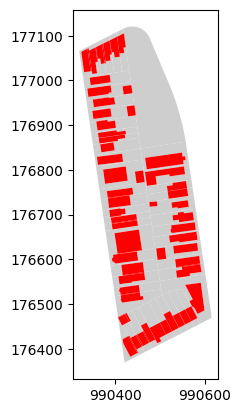

In [85]:
ax = lots_bldgs_union[lots_bldgs_union.globalid.isna()].plot(color="#cecece")
lots_bldgs_union[lots_bldgs_union.globalid.notna()].plot(ax=ax, color="red")

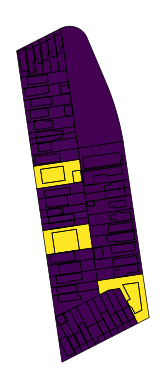

In [86]:
ax = lots_bldgs_union[lots_bldgs_union.globalid.isna()].plot("Lot")
lots_bldgs_union[lots_bldgs_union.globalid.notna()].plot("Lot", ax=ax)
lots_bldgs_union.boundary.plot(color="black", ax=ax, linewidth=0.5).set_axis_off()

In [87]:
lots_bldgs_union.globalid.unique()

array(['{492D704E-C7BB-4010-B912-2B7152D2E03F}',
       '{2C6AD805-18F7-4183-AC5D-14F18BF8CAD1}',
       '{9E3CB50C-E1DE-48F4-AE6E-BC9BDEB20641}',
       '{F60A0CAC-F33A-4EF4-B8EF-72139D8C5840}',
       '{1A2822B1-307E-4734-A03C-868BF017CEAB}',
       '{C9DFBDE6-CD85-430D-8DAF-33B94CEDE37A}',
       '{EF8B6A02-CF56-426E-B0E8-C2C60CE7A86A}',
       '{E232D182-1C01-4472-9A91-17EFE5FCBFC6}',
       '{5B3D1245-4BD5-4815-926A-FD764AB11797}',
       '{6030AEC8-EEDB-4C85-8CB8-825AC9CFE669}',
       '{4B03B134-BC98-4605-85D0-BEFDE5B01904}',
       '{0C2DE82E-890B-4169-B036-E466F6B3CFE2}',
       '{272AE125-FBD0-4DDF-8F48-4A98B5DAA718}',
       '{2B2BBDBB-1A17-4715-AA93-D2D9D4066F93}',
       '{8F33DB7B-6CFB-4C85-AA19-F90679C51CDA}',
       '{F99A57BD-7466-4723-925E-30D440E480A8}',
       '{CE4F332D-F088-447B-B438-C96FEE8FCD57}',
       '{65AD0853-6C9B-4FF3-A26D-C6D8FA7CDEFE}',
       '{B06D424D-E16A-4B13-9A45-A7E6BFA4B136}',
       '{16598E22-1AD0-4113-A67D-6AAFEC808867}',
       '{66826D5C-10

In [88]:
lots_bldgs_union["pct_bldg_lot_coverage"] = lots_bldgs_union.apply(
    lambda x: ((x.geometry.area / x.lot_area) * 100 if type(x.globalid) == str else -1),
    axis=1,
)

<Axes: >

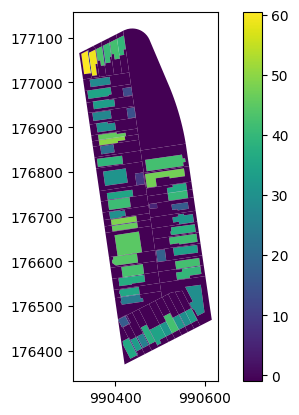

In [89]:
lots_bldgs_union.plot("pct_bldg_lot_coverage", legend=True)

## calculate soft sites (create new attributes)


In [90]:
def is_soft_site(r, threshold=0.33):
    if (
        r.BuiltFAR <= r.ResidFAR * threshold
        and r.LotArea > 10000
        and r.LandUse != "Open Space & Outdoor Recreation"
        and r.ResidFAR > 0
    ):
        return 1
    else:
        return 0

In [91]:
cb_307["soft_site"] = cb_307.apply(is_soft_site, axis=1)

In [92]:
cb_307["soft_site"].value_counts()

soft_site
0    13246
1       38
Name: count, dtype: int64

<Axes: >

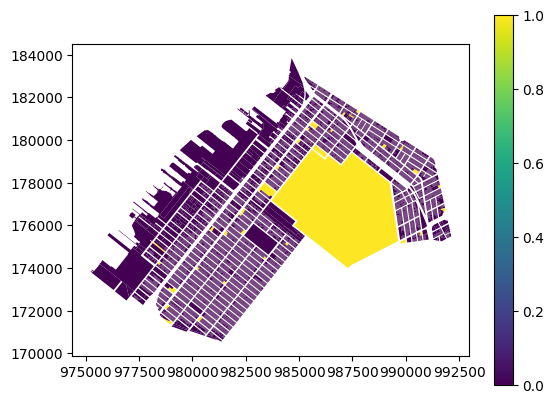

In [93]:
cb_307.plot("soft_site", legend=True)

In [ ]:
cb_307[cb_307.soft_site.eq(1)][["soft_site", "BuiltFAR", "ResidFAR"]]

,soft_site,BuiltFAR,ResidFAR
116,1,0.05,1.25
125,1,0.69,2.43
529,1,0.18,4.00
538,1,0.59,3.00
796,1,0.41,1.35
1642,1,0.97,6.02
1656,1,0.09,2.00
1696,1,0.00,6.02
1738,1,0.40,2.00
1905,1,0.32,2.00
